In [1]:
import torch
%matplotlib inline
from matplotlib import pyplot as plt
import math
import torch.nn.functional as F
from torch.nn.functional import relu
from torch import nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import random
import numpy as np
import gc
from pylab import *
import os
import random
import json
import pandas as pd
from scipy.stats import norm
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import sys
import matplotlib.pyplot as plt
import time

from linear_transformer import Transformer_F, attention, generate_data, in_context_loss, generate_data_inplace

np.set_printoptions(precision = 4, suppress = True)
torch.set_printoptions(precision=2)
device = torch.device("cuda")
torch.cuda.set_device(0)

In [2]:
# Set Hyperparameters

# Fixed
n_head = 1
d = 5
B = 1000
ma = 1
var = 0.05
shape_k = 0.1

# Number of Iterations to run
max_iters = 2000
hist_stride = 1  # stride for saved model paramters in `train.ipynb'
stride = 1 # stride for computing smoothness and gradient norms

# We vary the following parameters
n_layer = 3
mode = 'normal'
N = 20
alg = 'adam'
toclip = True
lr = 0.02
seed = 1

In [3]:
log_dir = 'log'
filename = log_dir + '/train_layer{}_N{}_{}_{}_{}_lr{}_sd{}.pth'.format(n_layer, N, mode, alg, toclip, lr, seed)

loaded_dict = torch.load(filename)
hist_list = loaded_dict['hist_list']

np.random.seed(99)
torch.manual_seed(99)
Z, y = generate_data(mode,N,d,B,shape_k)
Z = Z.to(device)
y = y.to(device)

model = Transformer_F(n_layer, n_head, d, var)
model = model.to(device)

gradient_norms = torch.zeros((max_iters-1)//stride)
for t in range(0,max_iters-1,stride):
    allparam_loaded = hist_list[t]
    with torch.no_grad():
        model.allparam.copy_(allparam_loaded)

    test_loss = in_context_loss(model,Z,y)
    test_loss.backward()
    gradient_norms[int(t/stride)] = torch.norm(model.allparam.grad).item()
    model.allparam.grad.zero_()


dir_smoothnesses = torch.zeros((max_iters-1)//stride)
for t in range(0,max_iters-1,stride):
    allparam_loaded = hist_list[t]
    allparam_loaded_n = hist_list[t+1]
    dp = (allparam_loaded_n - allparam_loaded)
    dp = dp/dp.norm()
    
    s = torch.zeros(1, device=device)
    def eval_dir_loss_hess(t):
        output = Z
        t_allparam = allparam_loaded + t*dp
        for i in range(n_layer):
            Zi = output
            residues = 0
            for j in range(n_head):
                Pij = t_allparam[i,j,0,:,:]
                Qij = t_allparam[i,j,1,:,:]
                residues = residues + attention(Pij,Qij,Zi)
            output = Zi + residues
        N= Z.shape[1]-1
        diff = output[:,N,d]+y
        loss = ((diff)**2).mean() 
        return loss
    
    dir_smoothness = torch.autograd.functional.hessian(eval_dir_loss_hess, tuple(s))
    dir_smoothnesses[t//stride] = dir_smoothness[0][0].item()

/tmp/ipykernel_3485906/564596101.py:6: RuntimeWarning: invalid value encountered in log
  sc = ax.scatter(np.log(gradient_norms), np.log(dir_smoothnesses), c=range(0,max_iters-1,stride), s=5)


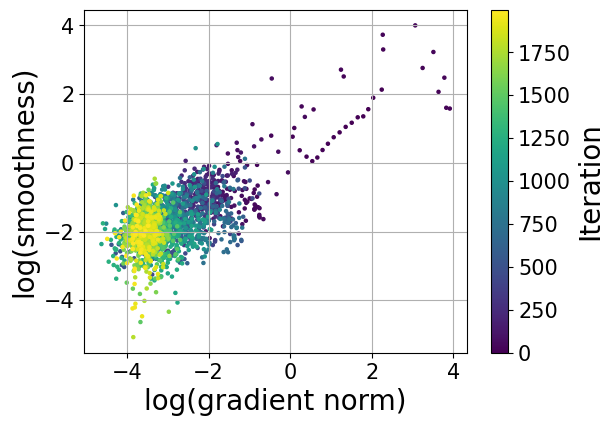

In [4]:
fig_dir = 'figures' 
os.makedirs(fig_dir, exist_ok=True)

fig, ax = plt.subplots(1, 1,figsize = (6.236, 4.362))

sc = ax.scatter(np.log(gradient_norms), np.log(dir_smoothnesses), c=range(0,max_iters-1,stride), s=5)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('log(gradient norm)',fontsize=20)
ax.set_ylabel('log(smoothness)',fontsize=20)
ax.grid(True)
cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Iteration', fontsize=20)

plt.tight_layout()
plt.savefig(fig_dir + '/smoothness_vs_gradnorm_layer{}_N{}_{}.pdf'.format(n_layer, N, mode), dpi=600)